<a href="https://colab.research.google.com/github/ahmadkhan242/Transfer-Learning-Model-hosted-on-Heroku-using-React-Flask/blob/main/roberta_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install transformers

     |████████████████████████████████| 1.4MB 7.9MB/s 
     |████████████████████████████████| 2.9MB 29.5MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d18d278caa68fd0014883af36b2b07a938abb5e388655f4bb96c7778c439227a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Importing library 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

import csv


## Dataset
### You can download Dataset from [GithHub repo](https://github.com/ahmadkhan242/Transfer-learning-in-NLP-using-RoBERTA)

In [1]:
! wget https://github.com/ahmadkhan242/Transfer-Learning-Model-hosted-on-Heroku-using-React-Flask/raw/main/Dataset/IMDB_prePro.csv

--2020-11-30 19:06:44--  https://github.com/ahmadkhan242/Transfer-Learning-Model-hosted-on-Heroku-using-React-Flask/raw/main/Dataset/IMDB_prePro.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ahmadkhan242/Transfer-Learning-Model-hosted-on-Heroku-using-React-Flask/main/Dataset/IMDB_prePro.csv [following]
--2020-11-30 19:06:44--  https://raw.githubusercontent.com/ahmadkhan242/Transfer-Learning-Model-hosted-on-Heroku-using-React-Flask/main/Dataset/IMDB_prePro.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48342774 (46M) [text/plain]
Saving to: ‘IMDB_prePro.csv’

IMDB_prePro.csv     100%[==

In [6]:
pre = pd.read_csv("./IMDB_prePro.csv")

In [7]:
pre.head()

,Unnamed: 0,review,sentiment
0,0,one reviewers mentioned watching <number> oz e...,positive
1,1,wonderful little production . < br / > < br / ...,positive
2,2,thought wonderful way spend time hot summer we...,positive
3,3,basically there's family little boy ( jake ) t...,negative
4,4,"petter mattei's "" love time money "" visually s...",positive


## Setting seed and device

In [ ]:
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


## Using Roterta Tokenizer from `transformers` library 

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

## Creating Train, Validation, and Test dataset using `torchtext` for pre-training 

In [ ]:
MAX_SEQ_LEN = 256
PRE_TRAINING_TRAIN_BATCH_SIZE = 32
PRE_TRAINING_VAL_BATCH_SIZE = 64
PRE_TRAINING_TEST_BATCH_SIZE = 64
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
PRE_TRAINING_DATASET_PATH = "./IMDB_prePro.csv"

# Define columns to read.
review_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

fields = {'review' : ('review', review_field), 'label' : ('label', label_field)}


train, valid, test = TabularDataset(path=PRE_TRAINING_DATASET_PATH, 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.1, 0.2], 
                                                                            stratified=True, 
                                                                            strata_field='label')

training_set_iter = Iterator(train, batch_size=PRE_TRAINING_TRAIN_BATCH_SIZE, device=device, train=True, shuffle=True, sort=False)
valid_set_iter = Iterator(valid, batch_size=PRE_TRAINING_VAL_BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
test_set_iter = Iterator(test, batch_size=PRE_TRAINING_TEST_BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

## Creating Model architecture using pretrained `RoBESRTa` weight from transformer library

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTA(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTA, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 256)
        self.bn1 = torch.nn.LayerNorm(256)
        self.l2 = torch.nn.Linear(256, 64)
        self.bn2 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l3 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l3(x)
        
        return x

## Defining `pretraining` function.

In [ ]:
train_loss_list = []
val_loss_list = []
epc_list = []

def pretrain(model, optimizer, training_set_iter, valid_set_iter, scheduler, num_epochs):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    best_valid_loss = float('Inf')
    
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0 
        for (review, label), _ in training_set_iter:
            mask = (review != PAD_INDEX).type(torch.uint8)
            y_pred = model(input_ids=review, attention_mask=mask)
            loss = criterion(y_pred, label)
            loss.backward()
            optimizer.step()    
            scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()
                
        model.eval()
        with torch.no_grad():                    
            for (review, target), _ in valid_set_iter:
                mask = (review != PAD_INDEX).type(torch.uint8)
                y_pred = model(input_ids=review, attention_mask=mask)
                loss = criterion(y_pred, target)
                valid_loss += loss.item()

        train_loss = train_loss / len(training_set_iter)
        valid_loss = valid_loss / len(valid_set_iter)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)
        epc_list.append(epoch)

        # print summary
        print('Epoch [{}/{}], Pre-Training Loss: {:.4f}, Val Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, valid_loss))
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss 
            # Saving Best Pre-Trained Model as .pth file
            torch.save({'model_state_dict': model.state_dict()}, "./best_pre_train_model.pth")
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
     
    
        
    print('Pre-training done!')

## Defining evaluate function to evaluate test dataset.

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['negative', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'positive'])

## Initiating pre-training 

In [ ]:
PRE_TRAINING_NUM_EPOCHS = 12
steps_per_epoch = len(training_set_iter)

PRE_TRAINING_model = ROBERTA(0.4)
PRE_TRAINING_model = PRE_TRAINING_model.to(device)


PRE_TRAINING_optimizer = AdamW(PRE_TRAINING_model.parameters(), lr=1e-4)
PRE_TRAINING_scheduler = get_linear_schedule_with_warmup(PRE_TRAINING_optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*PRE_TRAINING_NUM_EPOCHS)
print('Pre-training starts')
pretrain(model=PRE_TRAINING_model, training_set_iter=training_set_iter, valid_set_iter=valid_set_iter, optimizer=PRE_TRAINING_optimizer, scheduler=PRE_TRAINING_scheduler, num_epochs=PRE_TRAINING_NUM_EPOCHS)



Pre-training starts
Epoch [1/12], Pre-Training Loss: 0.7078, Val Loss: 0.6827
Epoch [2/12], Pre-Training Loss: 0.6719, Val Loss: 0.6661
Epoch [3/12], Pre-Training Loss: 0.6372, Val Loss: 0.5521
Epoch [4/12], Pre-Training Loss: 0.6238, Val Loss: 0.5479
Epoch [5/12], Pre-Training Loss: 0.6145, Val Loss: 0.5420
Epoch [6/12], Pre-Training Loss: 0.6115, Val Loss: 0.5382
Epoch [7/12], Pre-Training Loss: 0.6029, Val Loss: 0.5256
Epoch [8/12], Pre-Training Loss: 0.6031, Val Loss: 0.5233
Epoch [9/12], Pre-Training Loss: 0.6003, Val Loss: 0.5229
Epoch [10/12], Pre-Training Loss: 0.5954, Val Loss: 0.5118
Epoch [11/12], Pre-Training Loss: 0.5956, Val Loss: 0.5125
Epoch [12/12], Pre-Training Loss: 0.5934, Val Loss: 0.5073
Pre-training done!


## Ploting pre-training losses

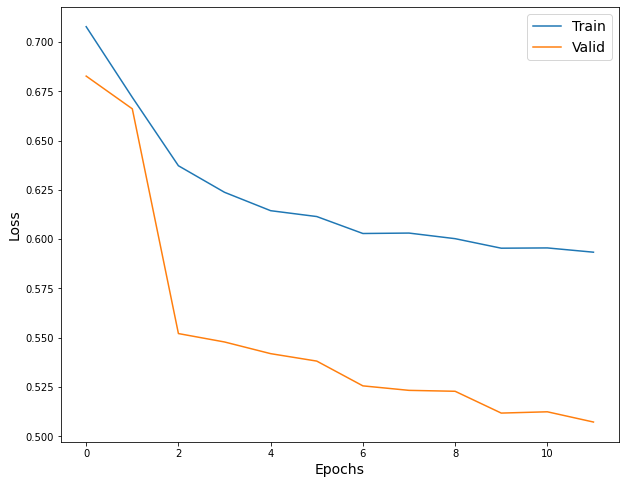

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           1     0.8113    0.7960    0.8036      2500
           0     0.7998    0.8148    0.8072      2500

    accuracy                         0.8054      5000
   macro avg     0.8055    0.8054    0.8054      5000
weighted avg     0.8055    0.8054    0.8054      5000



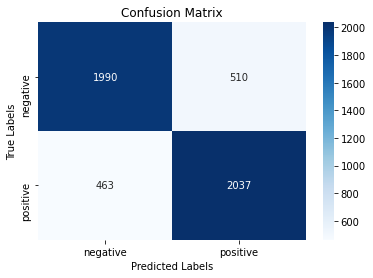

In [ ]:
# Evaluation matrix
evaluate(PRE_TRAINING_model, test_set_iter)

## Creating Train, Validation, and Test dataset using `torchtext` for Classification 

In [ ]:
CLASSIFIER_MAX_SEQ_LEN = 256
CLASSIFIER_TRAIN_BATCH_SIZE = 32
CLASSIFIER_VAL_BATCH_SIZE = 64
CLASSIFIER_TEST_BATCH_SIZE = 64
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
CLASSIFIER_DATASET_PATH = "./final_prepro.csv"

review_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=CLASSIFIER_MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

label_field = Field(sequential=False, use_vocab=False, batch_first=True)

fields = {'review' : ('review', review_field), 'label' : ('label', label_field)}


train, valid, test = TabularDataset(path=CLASSIFIER_DATASET_PATH, 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.1, 0.2], 
                                                                            stratified=True, 
                                                                            strata_field='label')

training_set_iterC = Iterator(train, batch_size=CLASSIFIER_TRAIN_BATCH_SIZE, device=device, train=True, shuffle=True, sort=False)
valid_set_iterC = Iterator(valid, batch_size=CLASSIFIER_VAL_BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
test_set_iterC = Iterator(test, batch_size=CLASSIFIER_TEST_BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

## Defining `Classifier` function.

In [ ]:
train_loss_list = []
val_loss_list = []
epc_list = []

def classifier(model, optimizer, training_set_iter, valid_set_iter, scheduler, num_epochs):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    
    criterion = torch.nn.CrossEntropyLoss()
    best_valid_loss = float('Inf')
    # Train loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0 
        for (review, label), _ in training_set_iter:
            mask = (review != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=review, attention_mask=mask)
            
            loss = criterion(y_pred, label)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
                
        model.eval()
        
        with torch.no_grad():                    
            for (review, target), _ in valid_set_iter:
                mask = (review != PAD_INDEX).type(torch.uint8)
                
                y_pred = model(input_ids=review, attention_mask=mask)
                
                loss = criterion(y_pred, target)
                
                valid_loss += loss.item()

        # Store train and validation loss history
        train_loss = train_loss / len(training_set_iter)
        valid_loss = valid_loss / len(valid_set_iter)
        
        model.train()
        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)
        epc_list.append(epoch)
        # print summary
        print('Epoch [{}/{}], Pre-Training Loss: {:.4f}, Val Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, valid_loss))
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss 
            # Saving Pre-Trained Model as .pth file
            torch.save({'model_state_dict': model.state_dict()}, "./final_model.pth")
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
     
    
        
    print('Training done!')

## Initiating classifier training

In [ ]:
CLASSIFIER_NUM_EPOCHS = 20
steps_per_epoch = len(training_set_iter)

CLASSIFIER_model = ROBERTA()
CLASSIFIER_model = CLASSIFIER_model.to(device)
preTrained = torch.load("./best_pre_train_model.pth")
CLASSIFIER_model.load_state_dict(preTrained, strict=False)

CLASSIFIER_optimizer = AdamW(CLASSIFIER_model.parameters(), lr=1e-4)
CLASSIFIER_scheduler = get_linear_schedule_with_warmup(CLASSIFIER_optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*CLASSIFIER_NUM_EPOCHS)
print('Training starts')
classifier(model=CLASSIFIER_model,optimizer=CLASSIFIER_optimizer, training_set_iter=training_set_iter, valid_set_iter=valid_set_iter,  scheduler=CLASSIFIER_scheduler, num_epochs=CLASSIFIER_NUM_EPOCHS)


Training starts
Epoch [1/20], Pre-Training Loss: 0.6994, Val Loss: 0.6873
Epoch [2/20], Pre-Training Loss: 0.6540, Val Loss: 0.5714
Epoch [3/20], Pre-Training Loss: 0.6154, Val Loss: 0.5508
Epoch [4/20], Pre-Training Loss: 0.5999, Val Loss: 0.5163
Epoch [5/20], Pre-Training Loss: 0.5934, Val Loss: 0.4926
Epoch [6/20], Pre-Training Loss: 0.5851, Val Loss: 0.4947
Epoch [7/20], Pre-Training Loss: 0.5845, Val Loss: 0.5087
Epoch [8/20], Pre-Training Loss: 0.5824, Val Loss: 0.4775
Epoch [9/20], Pre-Training Loss: 0.5819, Val Loss: 0.4998
Epoch [10/20], Pre-Training Loss: 0.5770, Val Loss: 0.4926
Epoch [11/20], Pre-Training Loss: 0.5781, Val Loss: 0.4747
Epoch [12/20], Pre-Training Loss: 0.5763, Val Loss: 0.4756
Epoch [13/20], Pre-Training Loss: 0.5690, Val Loss: 0.4764
Epoch [14/20], Pre-Training Loss: 0.5708, Val Loss: 0.4848
Epoch [15/20], Pre-Training Loss: 0.5735, Val Loss: 0.4795
Epoch [16/20], Pre-Training Loss: 0.5697, Val Loss: 0.4829
Epoch [17/20], Pre-Training Loss: 0.5659, Val Los

## Ploting Classifier training losses

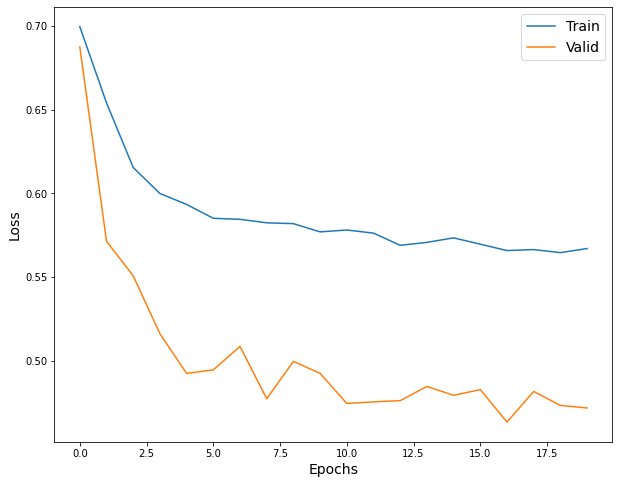

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

# Comparing previous f1, we have improved the f1 score

Classification Report:
              precision    recall  f1-score   support

           1     0.8169    0.8048    0.8108      2500
           0     0.8076    0.8196    0.8136      2500

    accuracy                         0.8122      5000
   macro avg     0.8123    0.8122    0.8122      5000
weighted avg     0.8123    0.8122    0.8122      5000



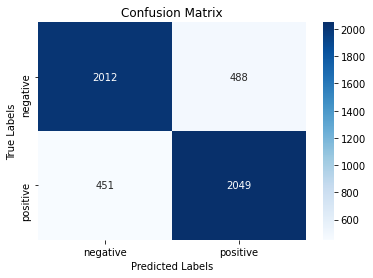

In [ ]:
evaluate(CLASSIFIER_model, test_set_iter)